# Домашнее задание «Сверточные нейронные сети: практическое применение»
Классификация изображений: Cats vs Dogs   
Обучить модель классификации изображение на 2 класса.    
Исходные данные и валидация решения на kaggle в рамках контеста Cats vs Dogs.   
Шаблон ipython-ноутбука для решения можно скачать по ссылке.    
Решения необходимо прислать в виде ipython-ноутбука с указанием значения метрики на Leaderboard. Задание засчитывается при значениях метрики Log Loss меньше 0.3.

In [1]:
# Загружаем библиотеки
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg16
import os
from random import shuffle
from glob import glob
%matplotlib inline
from matplotlib import pyplot as plt
import re
from keras import layers, models, optimizers

In [2]:
# Подключаем Google диск
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Загружаем данные
IMG_SIZE = (224, 224)  # размер входного изображения сети

train_files = glob('/content/drive/MyDrive/train/*.jpg')
test_files = glob('/content/drive/MyDrive/test/*.jpg')

In [4]:
# Указываем функции загрузки данных

def load_image(path, target_size=IMG_SIZE):
    """Загружаем входное изображение и предобрабатываем"""
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg16.preprocess_input(img)  # предобработка для VGG16

def fit_generator(files, batch_size=32):
    """Генерируем загрузки обучающих данных с диска"""
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if re.match('.*/dog\.\d', path) else 0. for path in files[i:j]])
            yield (x, y)

def predict_generator(files):
    """Генерируем загрузки тестовых изображений с диска"""
    while True:
        for path in files:
            yield np.array([load_image(path)])

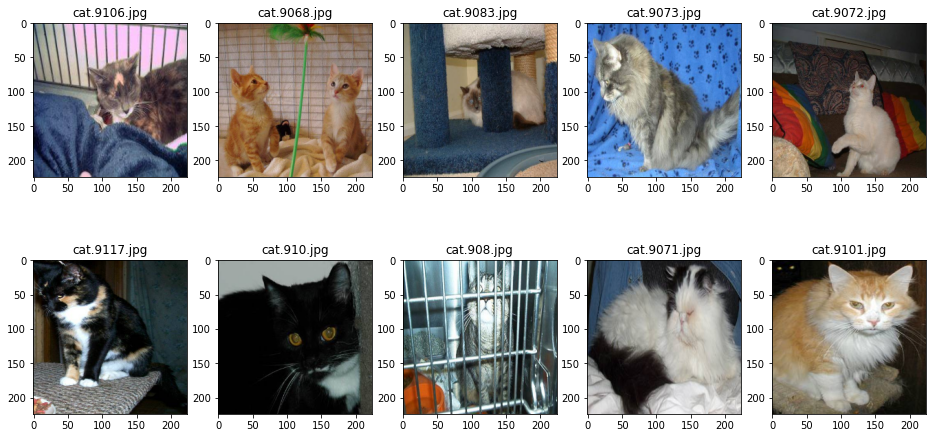

In [12]:
# Визуализируем примеры для обучения
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[:10], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

In [5]:
# Загружаем предобученную модель
base_model = vgg16.VGG16(weights='imagenet',
                         include_top=False,
                         input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
# Выводим архитектуру модели
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
# Добавляем полносвязный слой
# Фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-5].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации  
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')
# Выводим архитектуру модели
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [15]:
# Компилируем модель
model.compile(optimizer='adam', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss)
              metrics=['accuracy'])

val_samples = 5  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# Запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=10,  # число вызовов генератора за эпоху
          epochs=100,  # число эпох обучения
          validation_data=validation_data)

Epoch 1/100
10/10 [==============================] - 328s 35s/step - loss: 211.7740 - accuracy: 0.6344 - val_loss: 0.0435 - val_accuracy: 1.0000
Epoch 2/100
10/10 [==============================] - 4s 388ms/step - loss: 95.8513 - accuracy: 0.8156 - val_loss: 0.0477 - val_accuracy: 1.0000
Epoch 3/100
10/10 [==============================] - 4s 376ms/step - loss: 81.9026 - accuracy: 0.8375 - val_loss: 0.0508 - val_accuracy: 1.0000
Epoch 4/100
10/10 [==============================] - 4s 378ms/step - loss: 93.3203 - accuracy: 0.8719 - val_loss: 0.0533 - val_accuracy: 1.0000
Epoch 5/100
10/10 [==============================] - 4s 380ms/step - loss: 50.5478 - accuracy: 0.8906 - val_loss: 0.0553 - val_accuracy: 1.0000
Epoch 6/100
10/10 [==============================] - 4s 376ms/step - loss: 64.4240 - accuracy: 0.8875 - val_loss: 0.0570 - val_accuracy: 1.0000
Epoch 7/100
10/10 [==============================] - 4s 386ms/step - loss: 69.5133 - accuracy: 0.8750 - val_loss: 0.0587 - val_accuracy

In [16]:
# Осуществляем предсказание на проверочной выборке
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

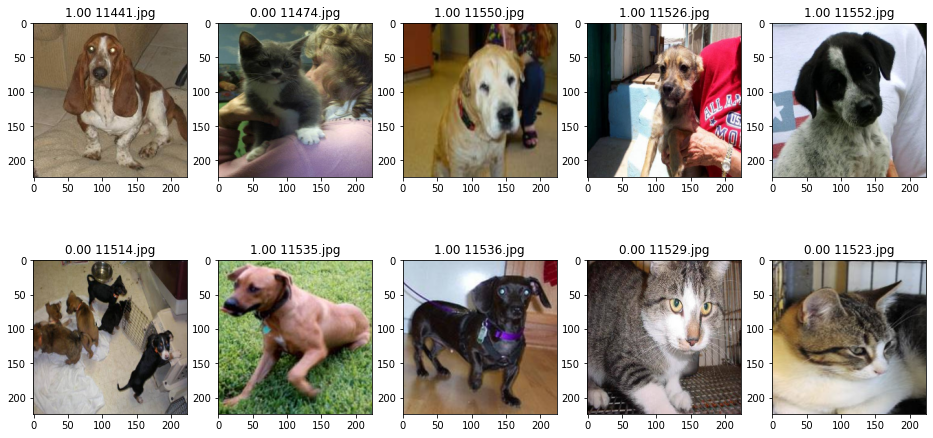

In [17]:
# Визуализируем результат
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

In [18]:
# Подготавливаем файл для отправки
with open('sample_submission.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

Получаем Score: 2.46569.

Попробуем улучшить работу модели.

In [6]:
# Добавляем полносвязный слой
# Фиксируем все веса предобученной сети
for layer in base_model.layers:
    layer.trainable = False

x = base_model.layers[-5].output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1,  # один выход (бинарная классификация)
                          activation='sigmoid',  # функция активации  
                          kernel_regularizer=tf.keras.regularizers.l1(1e-4))(x)

model = tf.keras.Model(inputs=base_model.input, outputs=x, name='dogs_vs_cats')
# Выводим архитектуру модели
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [7]:
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(5000, activation=None))
model.add(layers.Dropout(0.3))
model.add(layers.BatchNormalization())
model.add(layers.Activation('relu'))
model.add(layers.Flatten())
model.add(layers.Dense(5000, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [8]:
# Выводим архитектуру модели
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_1 (Dense)             (None, 5000)              125445000 
                                                                 
 dropout (Dropout)           (None, 5000)              0         
                                                                 
 batch_normalization (BatchN  (None, 5000)             20000     
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 5000)              0         
                                                        

In [9]:
# Компилируем модель
model.compile(optimizer='rmsprop', 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss)
              metrics=['accuracy'])

val_samples = 5  # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
]

# Запускаем процесс обучения
model.fit(train_data,
          steps_per_epoch=50,  # число вызовов генератора за эпоху
          epochs=30,  # число эпох обучения
          callbacks=callbacks,
          validation_data=validation_data)

Epoch 1/30
50/50 [==============================] - 45s 771ms/step - loss: 2.6242 - accuracy: 0.9100 - val_loss: 4.5627 - val_accuracy: 0.8000
Epoch 2/30
50/50 [==============================] - 21s 418ms/step - loss: 0.2209 - accuracy: 0.9463 - val_loss: 0.6542 - val_accuracy: 0.8000
Epoch 3/30
50/50 [==============================] - 20s 404ms/step - loss: 0.2101 - accuracy: 0.9419 - val_loss: 0.9419 - val_accuracy: 0.8000
Epoch 4/30
50/50 [==============================] - 20s 404ms/step - loss: 0.1236 - accuracy: 0.9644 - val_loss: 3.1684 - val_accuracy: 0.8000
Epoch 5/30
50/50 [==============================] - 20s 403ms/step - loss: 0.1531 - accuracy: 0.9712 - val_loss: 0.8933 - val_accuracy: 0.8000
Epoch 6/30
50/50 [==============================] - 20s 405ms/step - loss: 0.2260 - accuracy: 0.9550 - val_loss: 3.1514e-06 - val_accuracy: 1.0000
Epoch 7/30
50/50 [==============================] - 20s 401ms/step - loss: 0.2144 - accuracy: 0.9631 - val_loss: 0.0280 - val_accuracy: 1.

In [10]:
# Осуществляем предсказание на проверочной выборке
test_pred = model.predict(
    predict_generator(test_files), steps=len(test_files))

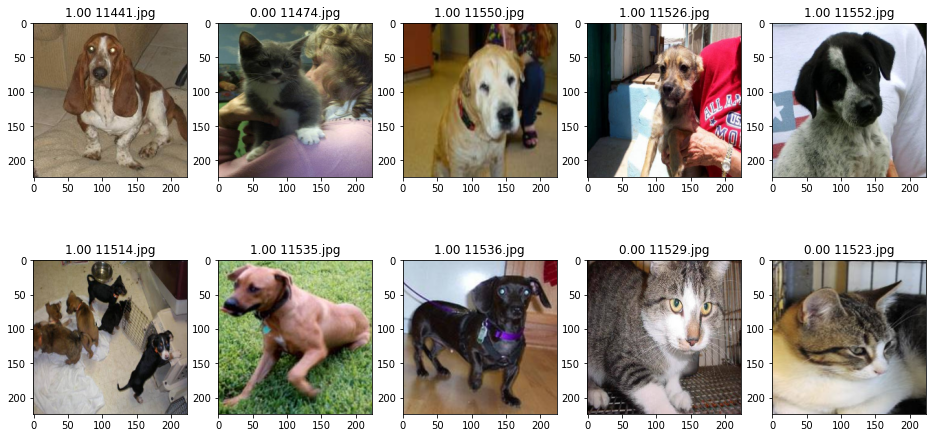

In [11]:
# Визуализируем результат
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

In [12]:
# Подготавливаем файл для отправки
with open('sample_submission.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

Получаем Score: 0.20605.
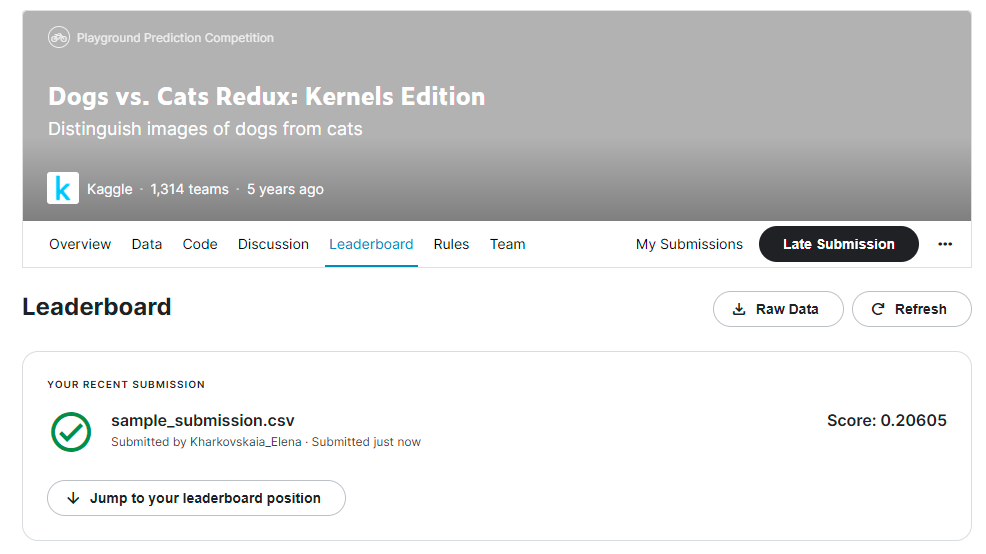  